In [1]:
from gas_turbine_cycle.core.turbine_lib import Compressor, CombustionChamber, Turbine, Load, Atmosphere, Sink, Source, \
Inlet, Outlet
from gas_turbine_cycle.gases import Air, KeroseneCombustionProducts, NaturalGasCombustionProducts
from gas_turbine_cycle.core.solver import NetworkSolver
from gas_turbine_cycle.tools import gas_dynamics as gd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import pickle
import config
%matplotlib inline

# Расчет цикла установки класса мощности 16 МВт

## Исходные данные для расчета

In [2]:
# мощность
N_e = config.N
# политропический КПД компрессора
eta_comp_stag_p = 0.88
# коэффициент сохранения полного давления во входном устройстве
sigma_inlet = 0.99
# относительный расход воздуха, отбираемого на прочие нужды помимо охлаждения лопаток турбины
g_outflow = 0.04
# коэффициент полноты сгорания
eta_burn = 0.995
# коэффициет сохранения полного давления в камере сгорания
sigma_comb = 0.98
# политропический КПД турбины компрессора
eta_t_comp_stag_p = 0.90
# политропический КПД силовой турбины
eta_t_power_stag_p = 0.90
# коэффициент сохранения полного давления в выходном устройстве
sigma_outlet = 0.99
# механический КПД
eta_m = 0.99
# КПД редуктора 
eta_r = 0.99
# Доля относительного расхода возвращаемого перед первой турбиной воздуха 
g_return1_rel = 0.4
# Доля относительного расхода возвращаемого перед второй турбиной воздуха 
g_return2_rel = 0.6

# Температуры газа для расчета
T_gas0 = config.T_gas_stag - 50
T_gas1 = config.T_gas_stag
T_gas2 = config.T_gas_stag + 50


# функция относительного расхода воздуха отбираемого на охлаждение турбины
def g_cool(T_gas):
    T_arr = [T_gas0, T_gas2]
    #return 1.4166e-4 * T_gas - 0.1445#+ 1.62e-4 * T_gas - 0.165 - 0.08
    return interp1d(T_arr, [0.11, 0.15], bounds_error=False, fill_value='extrapolate')(T_gas)

init_params = pd.DataFrame.from_dict({'Name': ['Политропический КПД компрессора',
                                               'Коэффициент сохранения давления во входном устройстве',
                                               'Расход воздуха, отбираемого на прочие нужды',
                                               'Коэффициент полноты сгорания',
                                               'Коэффициет сохранения давления в камере сгорания',
                                               'Политропический КПД турбины компрессора',
                                               'Политропический КПД силовой турбины',
                                               'Коэффициент сохранения давления в выходном устройстве',
                                               'Механический КПД',
                                               'Доля возвращаемого перед первой турбиной воздуха',
                                               'Доля возвращаемого перед первой турбиной воздуха'],
                                      'Value': [eta_comp_stag_p, sigma_inlet, g_outflow,  eta_burn, sigma_comb, 
                                                eta_t_comp_stag_p, eta_t_power_stag_p, sigma_outlet, eta_m, g_return1_rel,
                                                g_return2_rel]})
init_params

,Name,Value
0,Политропический КПД компрессора,0.880
1,Коэффициент сохранения давления во входном уст...,0.990
2,"Расход воздуха, отбираемого на прочие нужды",0.040
3,Коэффициент полноты сгорания,0.995
4,Коэффициет сохранения давления в камере сгорания,0.980
5,Политропический КПД турбины компрессора,0.900
6,Политропический КПД силовой турбины,0.900
7,Коэффициент сохранения давления в выходном уст...,0.990
8,Механический КПД,0.990
9,Доля возвращаемого перед первой турбиной воздуха,0.400


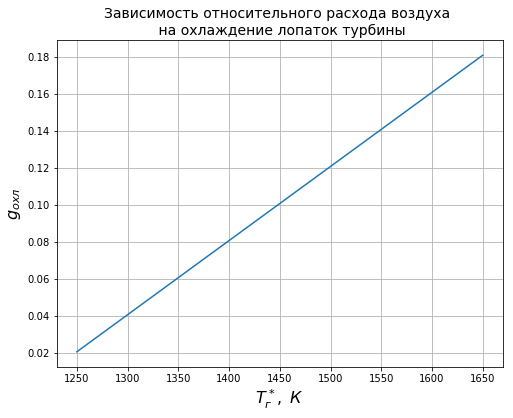

In [3]:
temp = np.linspace(1250, 1650, 50)
plt.figure(figsize=(8,6))
plt.plot(temp, [g_cool(t) for t in temp])
plt.grid()
plt.title('Зависимость относительного расхода воздуха \n на охлаждение лопаток турбины', fontsize=14)
plt.xlabel(r'$T_{г}^*,\ К$', fontsize=16)
plt.ylabel(r'$g_{охл}$', fontsize=16)
plt.show()

In [4]:

def get_2N_parameters(pi_c, T_g_stag):
    atmosphere = Atmosphere(T_stag_in_init=600)
    compressor = Compressor(pi_c=pi_c, eta_stag_p=eta_comp_stag_p, precision=0.001)
    inlet = Inlet(sigma=sigma_inlet)
    g_cooling = g_cool(T_g_stag)
    sink = Sink(g_cooling=g_cooling, g_outflow=g_outflow)
    comb_chamber = CombustionChamber(T_gas=T_g_stag, eta_burn=eta_burn, sigma_comb=sigma_comb, precision=0.001)
    source1 = Source(g_return=g_return1_rel * g_cooling)
    comp_turbine = Turbine(eta_stag_p=eta_t_comp_stag_p, precision=0.001, eta_m=eta_m, eta_r=1)
    source2 = Source(g_return=g_return2_rel * g_cooling)
    power_turbine = Turbine(eta_stag_p=eta_t_power_stag_p, p_stag_out_init=1e5, precision=0.001, 
                            eta_m=eta_m, eta_r=eta_r)
    outlet = Outlet(sigma=sigma_outlet)
    turb_load = Load(power=N_e)
    zero_load1 = Load(0)
    zero_load2 = Load(0)
    
    solver = NetworkSolver([atmosphere, inlet, comp_turbine, outlet, turb_load, zero_load1, zero_load2, 
                            power_turbine, compressor, sink, source1, source2, comb_chamber],precision=0.001, 
                           cold_work_fluid=Air(),
                           hot_work_fluid=NaturalGasCombustionProducts())
    solver.create_gas_dynamic_connection(atmosphere, inlet)
    solver.create_gas_dynamic_connection(inlet, compressor)
    solver.create_gas_dynamic_connection(compressor, sink)
    solver.create_gas_dynamic_connection(sink, comb_chamber)
    solver.create_gas_dynamic_connection(comb_chamber, source1)
    solver.create_gas_dynamic_connection(source1, comp_turbine)
    solver.create_gas_dynamic_connection(comp_turbine, source2)
    solver.create_gas_dynamic_connection(source2, power_turbine)
    solver.create_gas_dynamic_connection(power_turbine, outlet)
    solver.create_gas_dynamic_connection(outlet, atmosphere)
    solver.create_mechanical_connection(comp_turbine, compressor, zero_load1)
    solver.create_mechanical_connection(power_turbine, turb_load, zero_load2)
    solver.solve()
    N_e_specific = turb_load.consumable_labour * power_turbine.g_in
    G_air = turb_load.power / N_e_specific
    G_gas = comp_turbine.g_in * G_air
    C_e = 3600 * comb_chamber.g_fuel_prime * comb_chamber.g_in / N_e_specific
    eta_e = 3600 / (C_e * comb_chamber.Q_n)
    L_tc =  comp_turbine.total_labour
    L_tp = power_turbine.total_labour
    pi_tc = comp_turbine.pi_t
    pi_tp = power_turbine.pi_t
    T_tc = comp_turbine.T_stag_out
    T_tp = power_turbine.T_stag_out
    return eta_e, C_e, G_air, comp_turbine.p_stag_in, G_gas, L_tc, L_tp, pi_tc, pi_tp, T_tc, T_tp


## Анализ схемы 2Н при различных степенях повышения давления и температурах газа после турбины

In [5]:
pi_c_arr = np.linspace(5, 40, 18)
params_t0 = [get_2N_parameters(pi_c, T_gas0) for pi_c in pi_c_arr]
params_t1 = [get_2N_parameters(pi_c, T_gas1) for pi_c in pi_c_arr]
params_t2 = [get_2N_parameters(pi_c, T_gas2) for pi_c in pi_c_arr]

eta_e_arr_t0 = np.array([item[0] for item in params_t0])
C_e_arr_t0 = np.array([item[1] for item in params_t0])
G_air_arr_t0 = np.array([item[2] for item in params_t0])
p_gas_arr_t0 = np.array([item[3] for item in params_t0])
G_gas_arr_t0 = np.array([item[4] for item in params_t0])
L_tc_arr_t0 = np.array([item[5] for item in params_t0])
L_tp_arr_t0 = np.array([item[6] for item in params_t0])
pi_tc_arr_t0 = np.array([item[7] for item in params_t0])
pi_tp_arr_t0 = np.array([item[8] for item in params_t0])
T_tc_arr_t0 = np.array([item[9] for item in params_t0])


eta_e_arr_t1 = np.array([item[0] for item in params_t1])
C_e_arr_t1 = np.array([item[1] for item in params_t1])
G_air_arr_t1 = np.array([item[2] for item in params_t1])
p_gas_arr_t1 = np.array([item[3] for item in params_t1])
G_gas_arr_t1 = np.array([item[4] for item in params_t1])
L_tc_arr_t1 = np.array([item[5] for item in params_t1])
L_tp_arr_t1 = np.array([item[6] for item in params_t1])
pi_tc_arr_t1 = np.array([item[7] for item in params_t1])
pi_tp_arr_t1 = np.array([item[8] for item in params_t1])
T_tc_arr_t1 = np.array([item[9] for item in params_t1])


eta_e_arr_t2 = np.array([item[0] for item in params_t2])
C_e_arr_t2 = np.array([item[1] for item in params_t2])
G_air_arr_t2 = np.array([item[2] for item in params_t2])
p_gas_arr_t2 = np.array([item[3] for item in params_t2])
G_gas_arr_t2 = np.array([item[4] for item in params_t2])
L_tc_arr_t2 = np.array([item[5] for item in params_t2])
L_tp_arr_t2 = np.array([item[6] for item in params_t2])
pi_tc_arr_t2 = np.array([item[7] for item in params_t2])
pi_tp_arr_t2 = np.array([item[8] for item in params_t2])
T_tc_arr_t2 = np.array([item[9] for item in params_t2])



### Выбор степени повышения давления и температуры газа

In [6]:
# выбранная степень повышения давления
pi_c = 17
# выбранная температура газов 
T_g_stag = 1523

C_e_t0_int = interp1d(pi_c_arr, C_e_arr_t0)
C_e_t1_int = interp1d(pi_c_arr, C_e_arr_t1)
C_e_t2_int = interp1d(pi_c_arr, C_e_arr_t2)

eta_e_t0_int = interp1d(pi_c_arr, eta_e_arr_t0)
eta_e_t1_int = interp1d(pi_c_arr, eta_e_arr_t1)
eta_e_t2_int = interp1d(pi_c_arr, eta_e_arr_t2)

G_air_t0_int = interp1d(pi_c_arr, G_air_arr_t0)
G_air_t1_int = interp1d(pi_c_arr, G_air_arr_t1)
G_air_t2_int = interp1d(pi_c_arr, G_air_arr_t2)

### Графики различных параметров

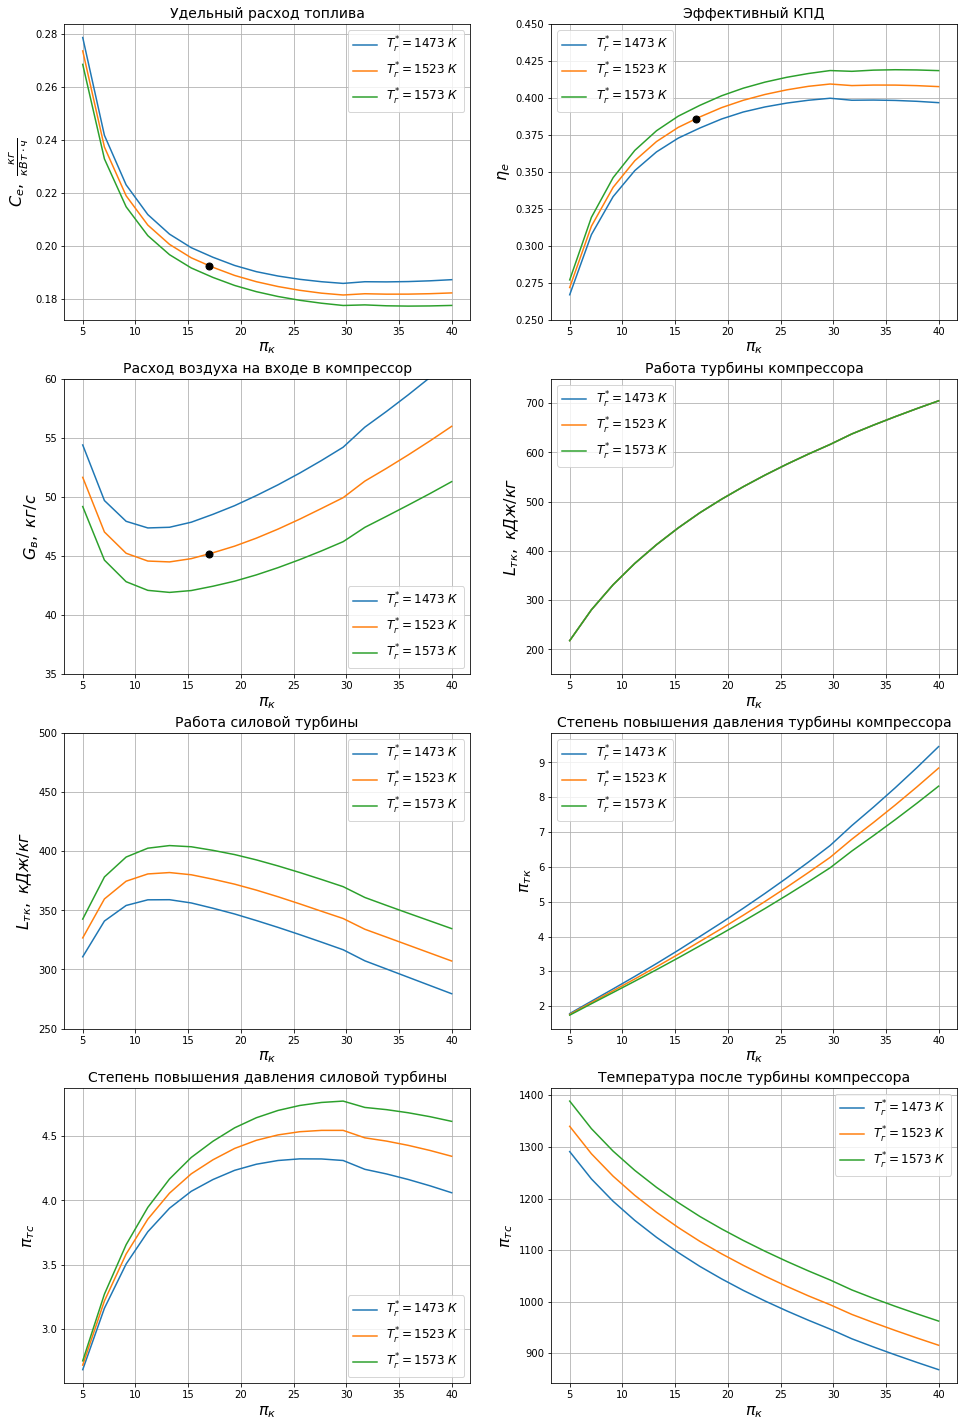

In [7]:
plt.figure(figsize=(16, 25))
plt.subplot(421)
plt.plot(pi_c_arr, C_e_arr_t0 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, C_e_arr_t1 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, C_e_arr_t2 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [C_e_t1_int(pi_c) * 1e3], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=12)
plt.title('Удельный расход топлива', fontsize=14)
plt.ylabel(r'$C_e,\ \frac{кг}{кВт\cdot ч}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(422)
plt.plot(pi_c_arr, eta_e_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, eta_e_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, eta_e_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [eta_e_t1_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.ylim(0.25, 0.45)
plt.legend(fontsize=12)
plt.title('Эффективный КПД', fontsize=14)
plt.ylabel(r'$\eta_e$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(423)
plt.plot(pi_c_arr, G_air_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, G_air_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, G_air_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [G_air_t1_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=12)
plt.title('Расход воздуха на входе в компрессор', fontsize=14)
plt.ylim(35, 60)
plt.ylabel(r'$G_{в},\ кг/с$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(424)
plt.plot(pi_c_arr, L_tc_arr_t0/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, L_tc_arr_t0/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, L_tc_arr_t0/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Работа турбины компрессора', fontsize=14)
plt.ylim(150, 750)
plt.ylabel(r'$L_{тк},\ кДж/кг$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(425)
plt.plot(pi_c_arr, L_tp_arr_t0/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, L_tp_arr_t1/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, L_tp_arr_t2/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Работа силовой турбины', fontsize=14)
plt.ylim(250, 500)
plt.ylabel(r'$L_{тк},\ кДж/кг$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(426)
plt.plot(pi_c_arr, pi_tc_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, pi_tc_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, pi_tc_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Степень повышения давления турбины компрессора', fontsize=14)
plt.ylabel(r'$\pi_{тк}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(427)
plt.plot(pi_c_arr, pi_tp_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, pi_tp_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, pi_tp_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Степень повышения давления силовой турбины', fontsize=14)
plt.ylabel(r'$\pi_{тс}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(428)
plt.plot(pi_c_arr, T_tc_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, T_tc_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, T_tc_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Температура после турбины компрессора', fontsize=14)
plt.ylabel(r'$\pi_{тс}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.show()

### Сохранение графиков для рпз

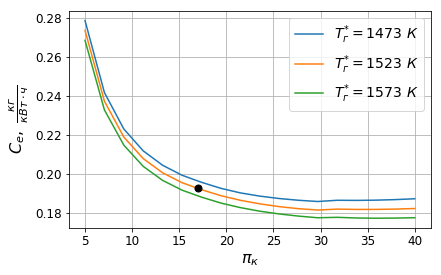

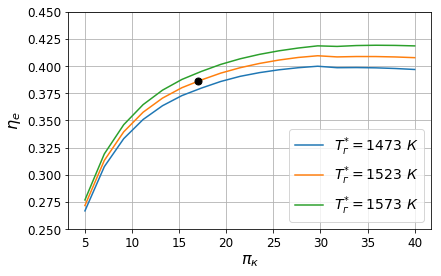

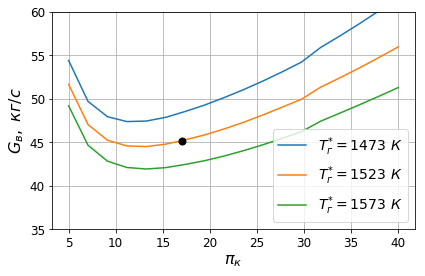

In [16]:
plt.figure(figsize=(6.5, 4))
plt.plot(pi_c_arr, C_e_arr_t0 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, C_e_arr_t1 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, C_e_arr_t2 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [C_e_t1_int(pi_c) * 1e3], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=14)
plt.ylabel(r'$C_e,\ \frac{кг}{кВт\cdot ч}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('plots/cycle_C_e.png')

plt.figure(figsize=(6.5, 4))
plt.plot(pi_c_arr, eta_e_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, eta_e_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, eta_e_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [eta_e_t1_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.ylim(0.25, 0.45)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r'$\eta_e$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.savefig('plots/cycle_eta_e.png')

plt.figure(figsize=(6.5, 4))
plt.plot(pi_c_arr, G_air_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, G_air_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, G_air_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [G_air_t1_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(35, 60)
plt.ylabel(r'$G_{в},\ кг/с$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.savefig('plots/cycle_G_air.png')

### Сохранение графиков для чертежей

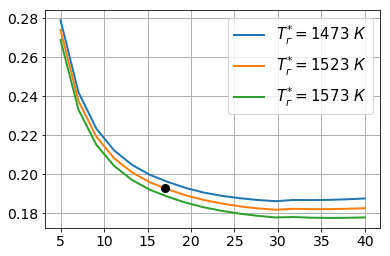

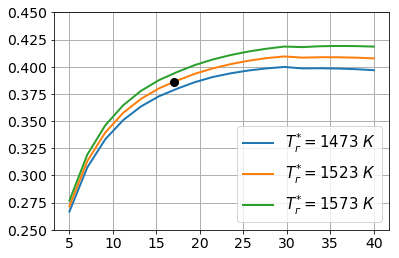

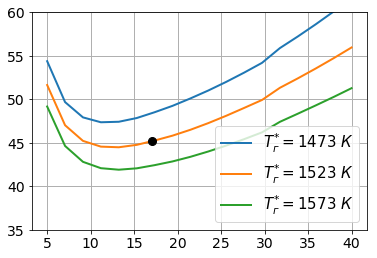

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(pi_c_arr, C_e_arr_t0 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0, lw=2)
plt.plot(pi_c_arr, C_e_arr_t1 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1, lw=2)
plt.plot(pi_c_arr, C_e_arr_t2 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2, lw=2)
plt.plot([pi_c], [C_e_t1_int(pi_c) * 1e3], linestyle='', marker='o', ms=8, mfc='black', mec='black')
plt.grid(linewidth=1)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('plots for drawing/cycle_C_e.png')

plt.figure(figsize=(6, 4))
plt.plot(pi_c_arr, eta_e_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0, lw=2)
plt.plot(pi_c_arr, eta_e_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1, lw=2)
plt.plot(pi_c_arr, eta_e_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2, lw=2)
plt.plot([pi_c], [eta_e_t1_int(pi_c)], linestyle='', marker='o', ms=8, mfc='black', mec='black')
plt.grid(linewidth=1)
plt.ylim(0.25, 0.45)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('plots for drawing/cycle_eta_e.png')

plt.figure(figsize=(6, 4))
plt.plot(pi_c_arr, G_air_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0, lw=2)
plt.plot(pi_c_arr, G_air_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1, lw=2)
plt.plot(pi_c_arr, G_air_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2, lw=2)
plt.plot([pi_c], [G_air_t1_int(pi_c)], linestyle='', marker='o', ms=8, mfc='black', mec='black')
plt.grid(linewidth=1)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(35, 60)
plt.savefig('plots for drawing/cycle_G_air.png')

### Оценка размеров лопаток соплового аппарата и среднего диаметра первой ступени турбины компрессора

#### Исходные данные для оценки

In [10]:
# скорость на входе в турбину
c_in = 90
# отношение длины лопатки к среднему диаметру
l_D_ratio = 1 / 6

#### Расчет

In [11]:
def get_inlet_size(T_gas, p_gas_arr, G_gas_arr):
    work_fluid = KeroseneCombustionProducts()
    work_fluid.T = T_gas
    # приведенная скорость газа
    lam_gas = c_in / gd.GasDynamicFunctions.a_cr(T_gas, work_fluid.k, work_fluid.R)
    # плотность по параметрам торможения по уровнению состояния
    rho_stag = p_gas_arr / (T_gas * work_fluid.R)
    # статическая плотностьпо ГДФ
    rho = rho_stag * gd.GasDynamicFunctions.eps_lam(lam_gas, work_fluid.k)
    # кольцевая площадь на входе
    square = G_gas_arr / (c_in * rho)
    # средний диаметр
    D_av_arr = np.sqrt(square / (np.pi * l_D_ratio))
    # длина лопаток
    l_arr = D_av_arr * l_D_ratio
    return D_av_arr, l_arr
    

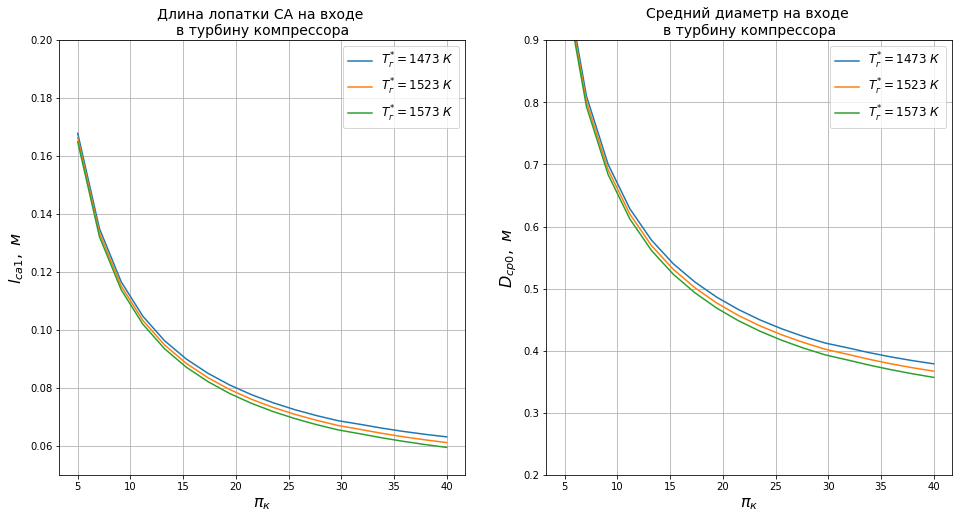

In [12]:
D_av_arr_t0, l_arr_t0 = get_inlet_size(T_gas0, p_gas_arr_t0, G_air_arr_t0)
D_av_arr_t1, l_arr_t1 = get_inlet_size(T_gas1, p_gas_arr_t1, G_air_arr_t1)
D_av_arr_t2, l_arr_t2 = get_inlet_size(T_gas2, p_gas_arr_t2, G_air_arr_t2)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(pi_c_arr, l_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, l_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, l_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.ylim(0.05, 0.20)
plt.title('Длина лопатки СА на входе \nв турбину компрессора', fontsize=14)
plt.ylabel(r'$l_{са1},\ м$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.subplot(122)
plt.plot(pi_c_arr, D_av_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, D_av_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, D_av_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.title('Средний диаметр на входе \nв турбину компрессора', fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0.2, 0.9)
plt.ylabel(r'$D_{ср0},\ м$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.show()

## Расчет цикла для выбранной степени повышения давления

In [13]:
atmosphere = Atmosphere(T_stag_in_init=600)
compressor = Compressor(pi_c=pi_c, eta_stag_p=eta_comp_stag_p, precision=0.001)
inlet = Inlet(sigma=sigma_inlet)
g_cooling = g_cool(T_g_stag)
sink = Sink(g_cooling=g_cooling, g_outflow=g_outflow)
comb_chamber = CombustionChamber(T_gas=T_g_stag, eta_burn=eta_burn, sigma_comb=sigma_comb, precision=0.001)
source1 = Source(g_return=g_return1_rel * g_cooling)
comp_turbine = Turbine(eta_stag_p=eta_t_comp_stag_p, precision=0.001, eta_m=eta_m, eta_r=1)
source2 = Source(g_return=g_return2_rel * g_cooling)
power_turbine = Turbine(eta_stag_p=eta_t_power_stag_p, p_stag_out_init=1e5, precision=0.001, 
                        eta_m=eta_m, eta_r=eta_r)
outlet = Outlet(sigma=sigma_outlet)
turb_load = Load(power=16e6)
zero_load1 = Load(0)
zero_load2 = Load(0)

solver = NetworkSolver([atmosphere, inlet, comp_turbine, outlet, turb_load, zero_load1, zero_load2, 
                        power_turbine, compressor, sink, source1, source2, comb_chamber],precision=0.001, 
                        cold_work_fluid=Air(),
                        hot_work_fluid=NaturalGasCombustionProducts())
solver.create_gas_dynamic_connection(atmosphere, inlet)
solver.create_gas_dynamic_connection(inlet, compressor)
solver.create_gas_dynamic_connection(compressor, sink)
solver.create_gas_dynamic_connection(sink, comb_chamber)
solver.create_gas_dynamic_connection(comb_chamber, source1)
solver.create_gas_dynamic_connection(source1, comp_turbine)
solver.create_gas_dynamic_connection(comp_turbine, source2)
solver.create_gas_dynamic_connection(source2, power_turbine)
solver.create_gas_dynamic_connection(power_turbine, outlet)
solver.create_gas_dynamic_connection(outlet, atmosphere)
solver.create_mechanical_connection(comp_turbine, compressor, zero_load1)
solver.create_mechanical_connection(power_turbine, turb_load, zero_load2)
solver.solve()
N_e_specific = turb_load.consumable_labour * power_turbine.g_in
G_air = turb_load.power / N_e_specific
G_gas = comp_turbine.g_in * G_air
C_e = 3600 * comb_chamber.g_fuel_prime * comb_chamber.g_in / N_e_specific
G_fuel = comb_chamber.g_fuel_prime * comb_chamber.g_in * G_air
eta_e = 3600 / (C_e * comb_chamber.Q_n)
L_tc =  comp_turbine.total_labour
L_tp = power_turbine.total_labour
H_tc = comp_turbine.work_fluid.c_p_av_int * comp_turbine.T_stag_in * \
(1 - comp_turbine.pi_t ** ((1 - comp_turbine.k) / comp_turbine.k))
pi_tc = comp_turbine.pi_t
pi_tp = power_turbine.pi_t
T_tc = comp_turbine.T_stag_out
# относительный суммарный расход возвращаемого воздуха, отнесенный к расходу воздуха на входе в турбину компрессора 
g_ret_turb_inlet = (source1.g_return + source2.g_return) * G_air / G_gas

params = pd.DataFrame.from_dict({'Name': ['pi_к',
                                         'p_к, МПа',
                                         'T_к, К',
                                         'T_г, К', 
                                         'T_вых, C',
                                         'eta_e',
                                         'C_e, кг/(Вт*ч)',
                                         'G_к, кг/с',
                                         'L_тк, кДж/кг',
                                         'alpha',
                                         'G_тк, кг/с',
                                         'T_тк, К',
                                         'pi_тк',
                                         'p_г, МПа',
                                         'G_возвр / G_тк',
                                         'g_охл',
                                         'G_топл, кг/с',
                                         "g_топл'",
                                         'g_топл'],
                                 'Value': [pi_c, compressor.p_stag_out / 1e6, compressor.T_stag_out, T_g_stag, 
                                           round(outlet.T_stag_out - 273, 0),
                                           round(eta_e, 4), 
                                           C_e, round(G_air, 2),  L_tc/1e3, comb_chamber.alpha_out, 
                                           comp_turbine.g_in * G_air, 
                                           comp_turbine.T_stag_out, comp_turbine.pi_t, comp_turbine.p_stag_in / 1e6,
                                           g_ret_turb_inlet, g_cooling, 
                                           round(G_fuel, 3),
                                           round(comb_chamber.g_fuel_prime, 4),
                                           round(comb_chamber.g_fuel_out, 4)],})


### Параметры цикла для выбранной степени повышения давления и температуры

In [14]:
params

,Name,Value
0,pi_к,17
1,"p_к, МПа",1.683
2,"T_к, К",712.471
3,"T_г, К",1523
4,"T_вых, C",534
5,eta_e,0.3859
6,"C_e, кг/(Вт*ч)",0.000192678
7,"G_к, кг/с",45.18
8,"L_тк, кДж/кг",478.496
9,alpha,2.62493


### Сохранение результатов расчета в файл

In [15]:
unit_arr = [atmosphere, inlet, comp_turbine, outlet, turb_load, zero_load1, zero_load2, 
                        power_turbine, compressor, sink, source1, source2, comb_chamber]
with open('output results/cycle.cyc', 'wb') as file:
    pickle.dump(unit_arr, file)